# Database Exploration

By **Franklin Oliveira**

-----
This notebook contains some code written in order for me (Franklin) to get accquainted with the `crustacea` database. Here you'll find some basic data treatment and some insights that did show up as I started to understand all the information on file <font color='blue'>'Planilha geral Atualizda FINAL com correções.xlsx'</font>.

In [13]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Importing data...

In [7]:
excel = pd.ExcelFile('Planilha geral Atualizda FINAL com correções.xlsx')
sheet_name = excel.sheet_names

print('The excel file contains the following sheets:', sheet_name)
print('\nDatabase is in sheet:', sheet_name[0])

The excel file contains the following sheets: ['Banco de Dados Colecao Carcinol', 'Planilha1']

Database is in sheet: Banco de Dados Colecao Carcinol


In [8]:
db = excel.parse(sheet_name[0], sep=';', encoding='utf-8-sig')

In [11]:
db.head()

,Acronimo+Catalog Number,Catalog Number,Cataloger First Name,Cataloger Middle,Cataloger Last Name,Cataloged Date,offline,Input Type,Alt Cat Number,reserved,...,waterBody,Continent,Country,State,County,Latitude1,Longitude1,Datum,Latitude/Longitude Type,Lat/Long Method
0,MNRJcarcino 000001,1.0,NaN,NaN,Legado,1980/10/30,False,Donation,NaN,False,...,Oceano Atlantico Sul,America do Sul,Brasil,Parana,NaN,25.830035 S,48.528374 W,NaN,Point,NaN
1,MNRJcarcino 000002,2.0,NaN,NaN,Legado,1980/10/31,False,Donation,NaN,False,...,Oceano Atlantico Sul,America do Sul,Brasil,Pernambuco,NaN,NaN,NaN,NaN,NaN,NaN
2,MNRJcarcino 000003,3.0,NaN,NaN,Legado,1980/10/31,False,Donation,NaN,False,...,Oceano Atlantico Sul,America do Sul,Brasil,Rio de Janeiro,Rio de Janeiro,23.00347 S,43.640745 W,NaN,Point,NaN
3,MNRJcarcino 000004,4.0,NaN,NaN,Legado,1980/10/30,False,Donation,NaN,False,...,Oceano Atlantico Sul,America do Sul,Brasil,Parana,NaN,NaN,NaN,NaN,NaN,NaN
4,MNRJcarcino 000005,5.0,NaN,NaN,Legado,1980/10/31,False,Donation,NaN,False,...,Oceano Atlantico Sul,America do Sul,Brasil,Ceara,Fortaleza,3.811753 S,38.478649 W,NaN,Point,NaN


In [18]:
for col in db.columns:
    print('-', col)

- Acronimo+Catalog Number
- Catalog Number
- Cataloger First Name
- Cataloger Middle
- Cataloger Last Name
- Cataloged Date
- offline
- Input Type
- Alt Cat Number
- reserved
- Object Condition
- Count Amount
- associatedTaxa
- Females
- Males
- Ind
- Adults
- Young
- Larvae
- Egg Mass
- Measurement\n Records
- Remarks
- Kingdom
- Phylum1
- Subphylum1
- Class1
- Subclass1
- Infraclass1
- Superorder1
- Order1
- Suborder1
- Infraorder1
- Superfamily1
- Family1
- Subfamily1
- Tribe1
- Genus1
- Species1
- Species Author1
- Type Status1
- Qualifier1
- Determiner First Name1
- Determiner Middle1
- Determiner Last Name1
- Determined Date1
- Phylum2
- Subphylum2
- Class2
- Subclass2
- Infraclass2
- Superorder2
- Order2
- Suborder2
- Infraorder2
- Superfamily2
- Family2
- Subfamily2
- Tribe2
- Genus2
- Species2
- Species Author2
- Type Status2
- Qualifier2
- Determiner First Name2
- Determiner Middle2
- Determiner Last Name2
- Determined Date2
- Prep Type1
- Count 1
- Description 1
- Prepared F

### Location columns

In [32]:
# DO a map?
db['Continent'].value_counts()

America do Sul      26306
Desconhecido         1188
America do Norte      276
Europa                268
Antartica             179
Oceania                98
America Central        85
Asia                   48
Africa                 44
Oceano Atlantico       33
Eurasia                23
Numero reservado        1
Name: Continent, dtype: int64

In [31]:
db['Country'].value_counts()  # there about 90 countries listed in the database (quite a lot!)
# DO remove 'desconhecido' = unknown country?

Brasil                   25882
Desconhecido              1097
Estados Unidos             190
Antartica                  179
Venezuela                  155
                         ...  
Estreito de Gibraltar        1
Suriname                     1
Kiribati                     1
Holanda                      1
Groelandia                   1
Name: Country, Length: 90, dtype: int64

### Lat Long columns

In [22]:
# there's an empty space between the number and S (use this to clean up)
db['Latitude1'].value_counts()

3.862872 S     228
17.986496 S    147
22.755182 S    134
22.947708 S     74
3.811753 S      70
              ... 
23.756296 S      1
23.612333 S      1
22.383272 S      1
6.984941 S       1
23.312778 S      1
Name: Latitude1, Length: 3744, dtype: int64

In [30]:
db[['Latitude1','Longitude1']].head(10)

,Latitude1,Longitude1
0,25.830035 S,48.528374 W
1,NaN,NaN
2,23.00347 S,43.640745 W
3,NaN,NaN
4,3.811753 S,38.478649 W
5,9.422624 S,35.48556 W
6,23.006136 S,43.634274 W
7,NaN,NaN
8,23.00347 S,43.640745 W
9,NaN,NaN


In [20]:
# doesn't bring any classification info
db['Latitude/Longitude Type'].value_counts()

Point    15286
Name: Latitude/Longitude Type, dtype: int64

In [21]:
# empty
db['Lat/Long Method'].value_counts()

Series([], Name: Lat/Long Method, dtype: int64)

<br>

<font color='red' size='5'>Listar colunas usadas nos gráficos e o que entendi delas </font>

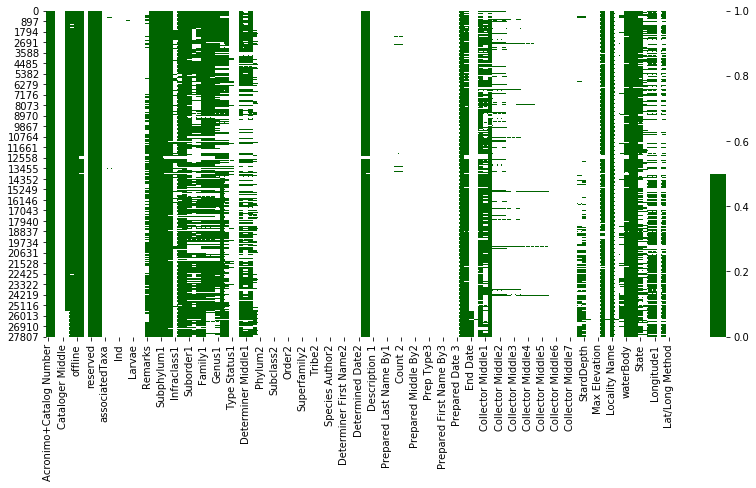

In [17]:
plt.figure(figsize=(14,6))
sns.heatmap(db.isna(), cmap=['darkgreen', 'white'])